In [3]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
x0 = np.random.rand(6*3,1)
xf = np.random.rand(6*3,1)*3
Q = np.eye(6*3)
R = np.eye(3*3)
Qf = np.eye(6*3)*100

u_ref = np.zeros((3*3,1))
N= 50
n_agents = 3
n_states = 6
n_inputs = 3
Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents

In [6]:
models = [quadDynamics6D,quadDynamics6D,quadDynamics6D]

In [7]:
ids = [i for i in range(n_agents)]

In [8]:
# quadDynamics6D(xf,Q,R,Qf,u_ref,N).cost()

In [11]:
dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [40]:
problem = quadProblem(dynamics)

In [41]:
problem

MPCProblem(
	MultiDynamicalModel(
))

In [49]:
dynamics.submodels[0].opti

Opti(Opti {
  instance #0
  #variables: 0 (nx = 0)
  #parameters: 0 (np = 0)
  #constraints: 0 (ng = 0)
  CasADi solver needs updating.
})

In [56]:
sol = quadProblem(x0,xf,Q,R,Qf,u_ref,N).solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2506
Number of nonzeros in inequality constraint Jacobian.:     1207
Number of nonzeros in Lagrangian Hessian.............:     1405

Total number of variables............................:      907
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:     1207
        inequality constraints with only lower bounds:      604
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      603

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8233604e+05 7.62e-01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [57]:
print(sol[0])

[[0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.76234467 0.76234467
  0.76234467 0.76234467 0.76234467 0.76234467 0.

In [59]:
xf

array([[1.1016381 ],
       [1.13960162],
       [1.93522757],
       [2.33565367],
       [0.67531796],
       [2.38863831]])

In [64]:
sol[0][:,-1]

array([0.76234467, 0.58401639, 0.00574344, 0.27576116, 0.72855949,
       0.62500652])

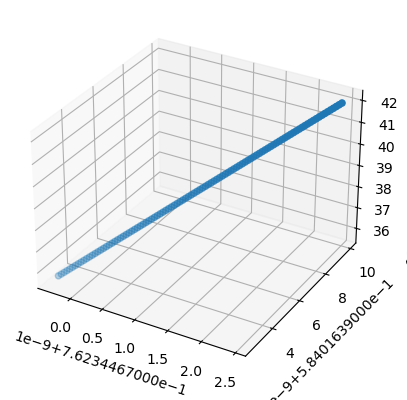

In [65]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sol[0][0,:],sol[0][1,:],sol[0][2,:])

